<a href="https://colab.research.google.com/github/Byeon-MJ/Computer_Vision_Project/blob/main/Image_Multi_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intel Image Classification

6가지 Class의 사진 분류 모델

## DataSet 준비

### Google Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Kaggle 연동 및 파일 다운로드

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mjbyeon","key":"53ea0c00f9c398afd45229ed1ac4779e"}'}

In [4]:
!ls -1ha kaggle.json

kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Intel Image 다운로드
!kaggle datasets download -d puneet6060/intel-image-classification

 99% 344M/346M [00:16<00:00, 22.6MB/s]
100% 346M/346M [00:16<00:00, 21.6MB/s]


### 데이터셋 준비

In [8]:
from zipfile import ZipFile

with ZipFile('intel-image-classification.zip') as z:
    z.extractall()

In [9]:
!rm intel-image-classification.zip

In [10]:
# # Google Drive로 폴더 이동
# !mv seg_pred /content/gdrive/MyDrive/CV/Intel\ Image\ Classification/
# !mv seg_test /content/gdrive/MyDrive/CV/Intel\ Image\ Classification/
# !mv seg_train /content/gdrive/MyDrive/CV/Intel\ Image\ Classification/

In [11]:
# # Google Drive 확인
# !ls /content/gdrive/MyDrive/CV/Intel\ Image\ Classification/seg_train/seg_train

## 모델 생성, 학습

### 모듈 임포트

In [12]:
import math
import os
import cv2
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import Model, layers

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.regularizers import l2

### ImageDataGenerator 인스턴스 생성

In [13]:
train_datagen = ImageDataGenerator(
    zoom_range=0.2,         # 20%까지 확대
    rotation_range=10,      # 10도까지 회전
    horizontal_flip=True,   # 좌우 뒤집기
    rescale=1./255)         # 픽셀 값을 0~1 범위로 변환

test_datagen = ImageDataGenerator(
    zoom_range=0.2,         # 20%까지 확대
    rotation_range=10,      # 10도까지 회전
    horizontal_flip=True,   # 좌우 뒤집기
    rescale=1./255)         # 픽셀 값을 0~1 범위로 변환

In [14]:
# train_generator, test_generator 객체 생성
train_generator = train_datagen.flow_from_directory(
    'seg_train/seg_train',
    batch_size=100,                 # batch size 정의
    class_mode='sparse',            # class는 sparse
    target_size=(150, 150))         # 이미지 크기 정의

test_generator = test_datagen.flow_from_directory(
    'seg_test/seg_test',
    batch_size=100,
    class_mode='sparse',
    target_size=(150, 150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Label name 찾는 함수 정의

In [15]:
def findKey(indices, search_value):
    for key, value in indices.items():
        if(value == search_value):
            return key
    return -1

### Train dataset Sample Display

Found 14034 images belonging to 6 classes.


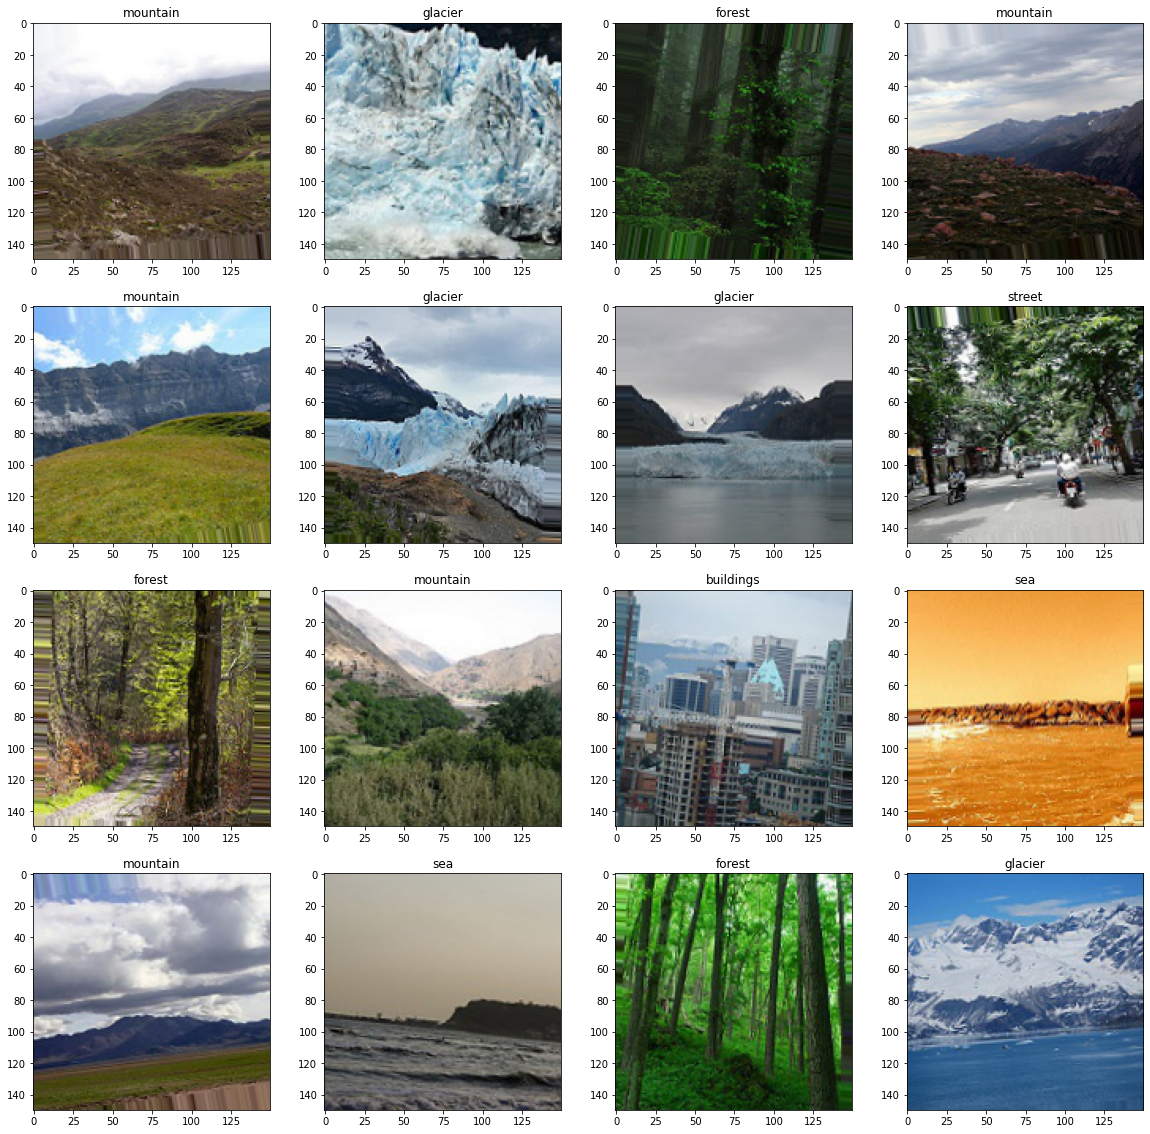

In [16]:
for X_batch, y_batch in train_datagen.flow_from_directory(
                        'seg_train/seg_train',
                        batch_size=100, class_mode='sparse', target_size=(150, 150)):
    plt.figure(figsize=(20, 20))
    
    # create a grid of 4 by 4 images
    for i in range(0, 16):
        ax = plt.subplot(4, 4, i+1)
        # 이미지의 label name을 찾아온다.
        ax.set_title(findKey(train_generator.class_indices, y_batch[i]))
        #train 샘플 이미지
        plt.imshow((X_batch[i].reshape(150, 150, 3)*255).astype(np.uint8))

    # show the plot
    plt.show()
    break

### 모델 생성

In [17]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), name="conv1"))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name="conv2"))
model.add(MaxPooling2D(pool_size=(3, 3), name='maxpool1'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv3'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv4'))
model.add(MaxPooling2D(pool_size=(3, 3), name='maxpool2'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv5'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv6'))
model.add(MaxPooling2D(pool_size=(3, 3), name='maxpool3'))
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 148, 148, 64)      1792      
                                                                 
 conv2 (Conv2D)              (None, 146, 146, 64)      36928     
                                                                 
 maxpool1 (MaxPooling2D)     (None, 48, 48, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 46, 46, 128)       73856     
                                                                 
 conv4 (Conv2D)              (None, 44, 44, 128)       147584    
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 128)       0         
                                                                 
 conv5 (Conv2D)              (None, 12, 12, 256)       2

### 모델 학습

In [18]:
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = 140,
                              epochs=40,
                              validation_data = test_generator,
                              validation_steps=30)

<ipython-input-18-c61e44172d55>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator,


Epoch 1/40
140/140 [==============================] - 122s 777ms/step - loss: 2.7046 - accuracy: 0.4536 - val_loss: 2.1611 - val_accuracy: 0.5533
Epoch 2/40
140/140 [==============================] - 110s 785ms/step - loss: 1.9290 - accuracy: 0.6015 - val_loss: 1.6952 - val_accuracy: 0.6633
Epoch 3/40
140/140 [==============================] - 104s 743ms/step - loss: 1.6230 - accuracy: 0.6581 - val_loss: 1.5062 - val_accuracy: 0.6833
Epoch 4/40
140/140 [==============================] - 109s 773ms/step - loss: 1.4409 - accuracy: 0.6937 - val_loss: 1.3944 - val_accuracy: 0.6977
Epoch 5/40
140/140 [==============================] - 105s 749ms/step - loss: 1.3332 - accuracy: 0.7116 - val_loss: 1.2489 - val_accuracy: 0.7427
Epoch 6/40
140/140 [==============================] - 108s 770ms/step - loss: 1.2293 - accuracy: 0.7348 - val_loss: 1.1855 - val_accuracy: 0.7477
Epoch 7/40
140/140 [==============================] - 107s 761ms/step - loss: 1.1575 - accuracy: 0.7511 - val_loss: 1.1067 -

### 모델 평가

In [19]:
score = model.evaluate(test_generator, steps=30, verbose=1)
print('Test loss:', score[0])
print('Test accuracy', score[1]*100)

30/30 [==============================] - 16s 538ms/step - loss: 0.5050 - accuracy: 0.8633
Test loss: 0.5049521327018738
Test accuracy 86.33333444595337


### loss, accuracy Graph

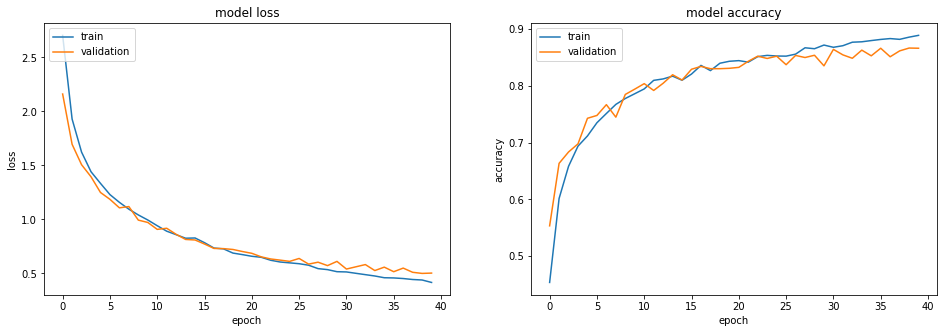

In [20]:
# loss graph
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

### 모델 저장

In [21]:
model.save('Intel_image_classification_model.h5')
print('Saved model to disk')

Saved model to disk


In [22]:
# 저장된 모델 drive로 이동
!mv Intel_image_classification_model.h5 /content/gdrive/MyDrive/CV/Intel\ Image\ Classification

## Test 파일 예측

### 이미지 파일 로드 함수 정의

In [23]:
# 이미지 파일들을 읽어오는 함수를 정의
def get_images(directory):
    Images = []
    pred_img_cnt = 25                                           # 예측할 이미지 수 설정
    i = 0

    for image_file in os.listdir(directory):                    # 디렉토리로부터 파일을 불러온다.
        i += 1
        if i > pred_img_cnt: break
        else:
            image = cv2.imread(directory + r'/' + image_file)   # 불러온 이미지를 openCV로 읽어들인다.

            imgae = cv2.resize(image,(150, 150))                # 이미지 크기 재조정
            Images.append(image)
    return Images

### 이미지 로드

In [24]:
pred_images = get_images('seg_pred/seg_pred')
pred_images = np.array(pred_images) * 1./255
pred_images.shape

(25, 150, 150, 3)

### 분류 예측

In [25]:
prediction = model.predict(pred_images, verbose=1)

1/1 [==============================] - 1s 783ms/step


In [26]:
# class 인덱스 확인
print(test_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


### 예측 결과 표시

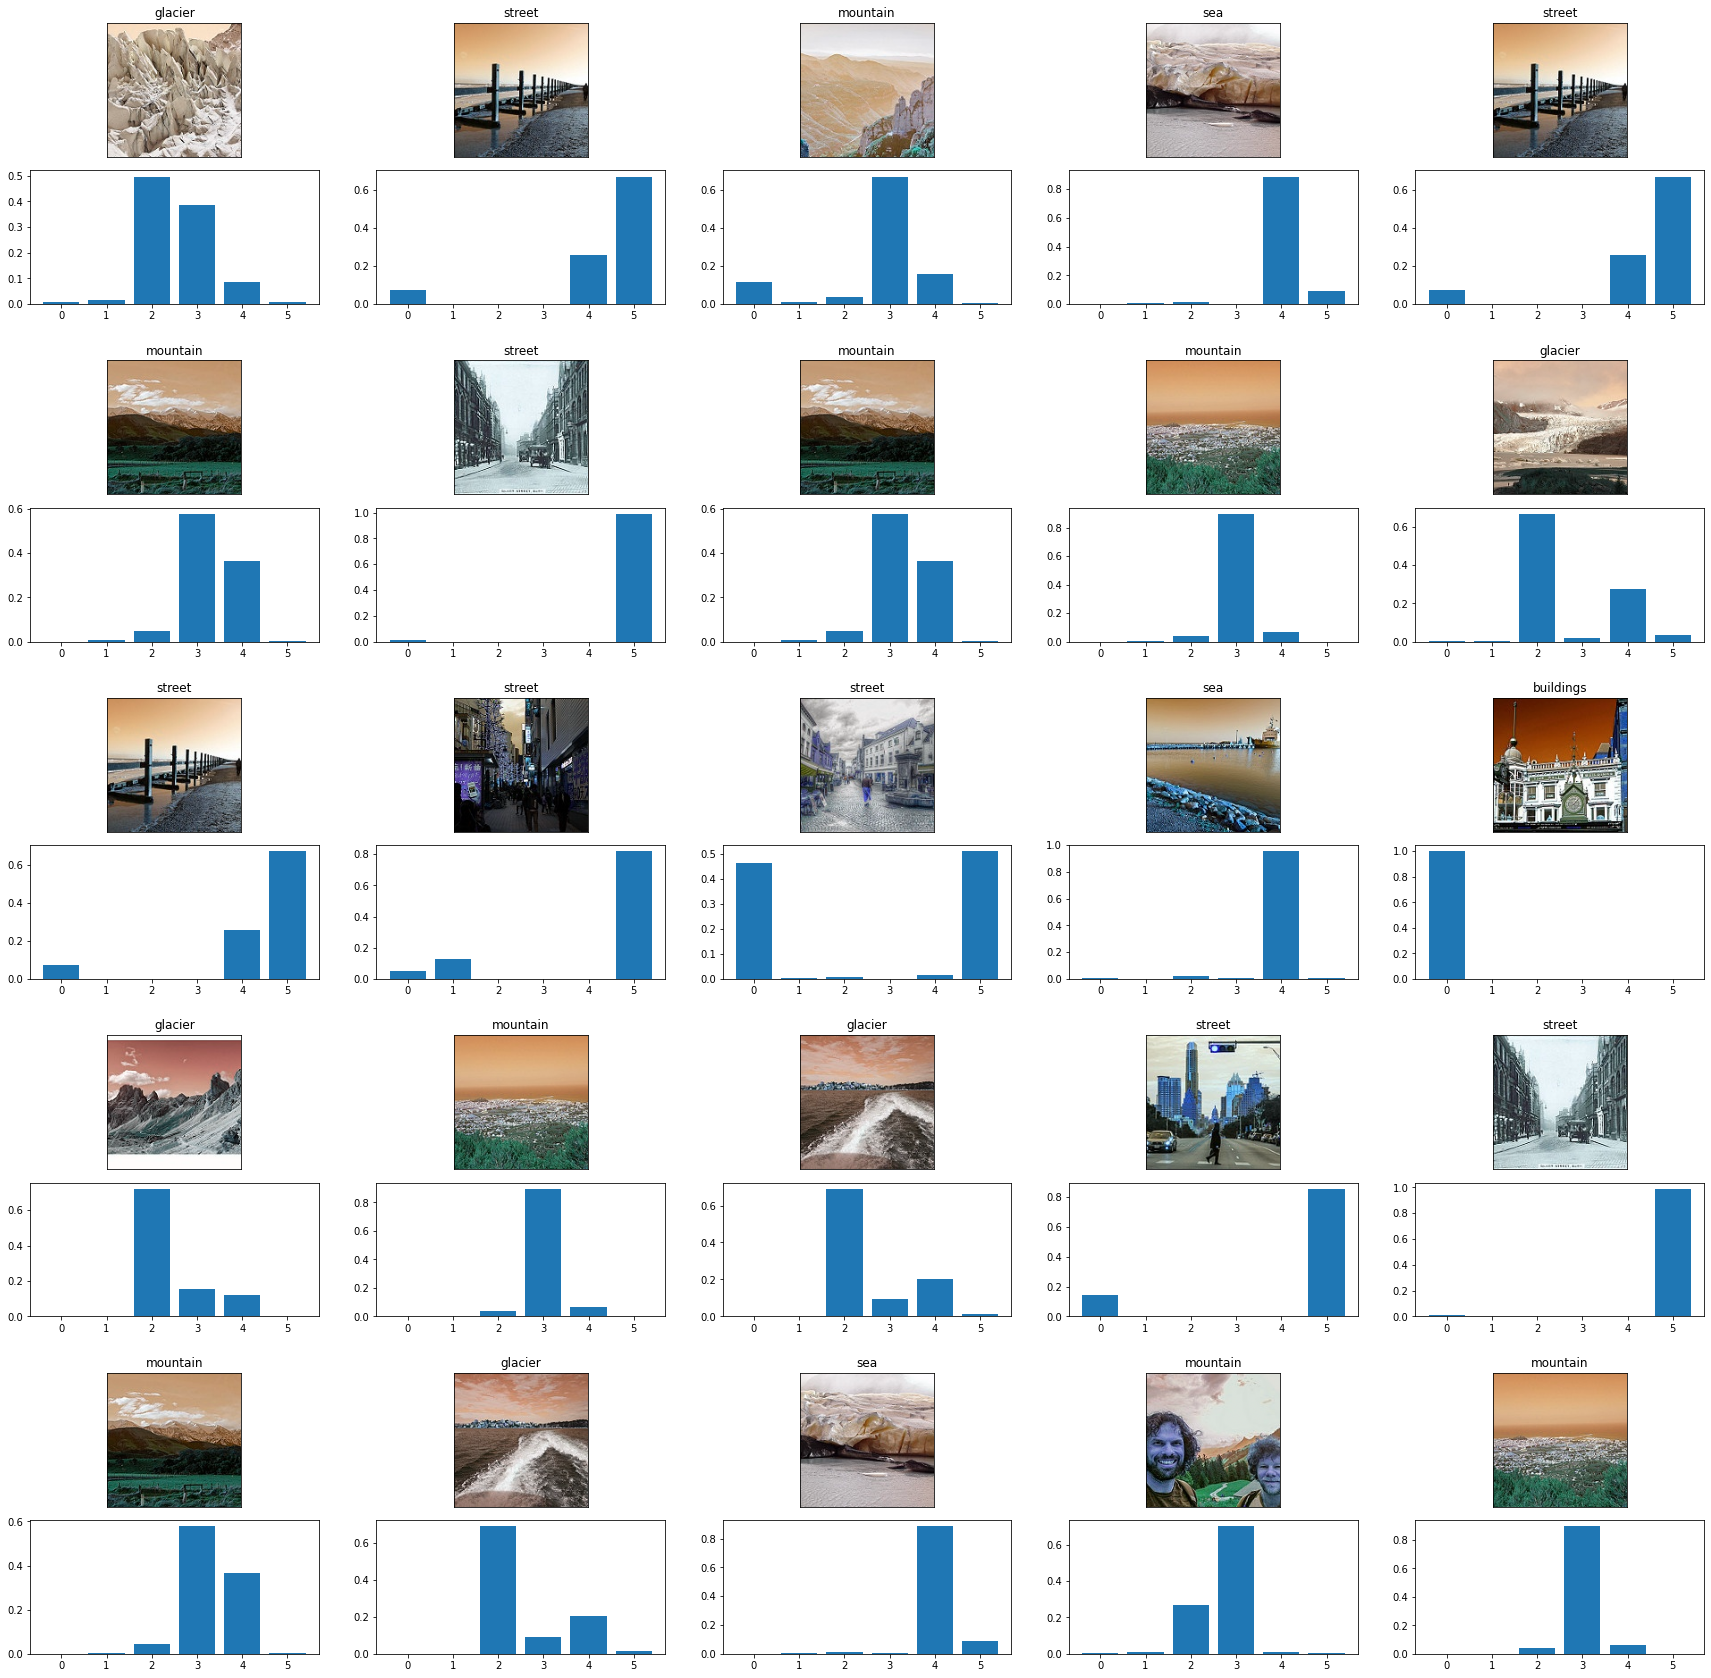

In [27]:
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0, len(pred_images)-1)
    pred_image = np.array([pred_images[rnd_number]])

    # 이미지의 label name을 찾는다.
    pred_class = findKey(train_generator.class_indices,
                         np.argmax(prediction[rnd_number]))
    
    # 예측된 결과(확률값)를 1차원 배열(6칸)로 reshape
    pred_prob = prediction[rnd_number].reshape(6)

    for j in range(2):
        if (j%2) == 0:                              # 이미지와 title(label name) 출력
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:                                       # 확률값을 그래프 형태로 출력
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)

    fig.show()